<a href="https://colab.research.google.com/github/SimeonHristov99/AI_PredictChurn_Adaboost/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description: This notebook performs data cleaning, feature engineering and classification using Adaboost in order to predict the churn rate for the "churn rate" dataset.

## Imports

In [774]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## Uploading the data set

In [775]:
df = pd.read_csv('/content/training_data.csv') # Assuming it is preloaded in Google Colab
df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,voice,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,20.75,0.0,15.25,35.7,42.00,211.45,125.0,1.0,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,0.00,0.0,0.00,0.0,288.80,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,0.00,0.0,0.00,0.0,157.05,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,45.00,50.1,23.25,64.9,239.55,1873.05,880.0,1.0,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,22.00,0.0,23.75,0.0,47.45,166.10,145.0,1.0,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


## Attribute types

In [776]:
df.shape

(200, 28)

In [777]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

There are 200 samples, each with 28 featrures (including the feature to be predicted - churn).

In [778]:
df.describe()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,voice,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
count,200.000000,200.000000,200.000000,200.000000,200.00000,200.00000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,35.505000,41.165000,11.650000,75.130000,2.82500,10.22500,0.425000,0.705000,0.290000,11.78925,13.240000,15.783250,14.358750,12.2170,577.770750,507.007500,650.663750,0.295000,0.275000,0.440000,0.45500,0.460000,0.440000,2.193285,3.229185,3.951015,2.475000,0.290000
std,21.640971,13.076803,10.158419,128.430468,1.28555,8.95743,0.495584,0.457187,0.454901,9.88725,15.643842,19.557103,14.781269,21.6326,746.608653,820.027858,941.470689,0.457187,0.447635,0.497633,0.49922,0.499648,0.497633,0.731282,0.281019,0.752553,1.079445,0.454901
min,1.000000,19.000000,0.000000,9.000000,1.00000,0.00000,0.000000,0.000000,0.000000,1.10000,0.000000,0.000000,0.000000,0.0000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.095000,1.749000,2.197000,1.000000,0.000000
25%,16.750000,31.000000,3.000000,31.000000,2.00000,3.00000,0.000000,0.000000,0.000000,5.53750,0.000000,0.000000,0.000000,0.0000,79.337500,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.711750,3.226500,3.434000,2.000000,0.000000
50%,33.500000,40.000000,9.000000,48.000000,3.00000,7.50000,0.000000,1.000000,0.000000,8.25000,0.000000,0.000000,12.500000,0.0000,289.525000,0.000000,342.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.110000,3.240000,3.871000,2.000000,0.000000
75%,55.250000,51.000000,18.000000,80.000000,4.00000,17.00000,1.000000,1.000000,1.000000,14.30000,24.750000,33.012500,20.750000,23.4625,806.762500,724.162500,921.250000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,2.660000,3.240000,4.382000,3.000000,1.000000
max,72.000000,76.000000,48.000000,1668.000000,5.00000,44.00000,1.000000,1.000000,1.000000,62.30000,68.500000,63.250000,109.250000,109.7000,4333.000000,4938.600000,7515.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,4.132000,4.227000,7.419000,4.000000,1.000000


In [779]:
for col in df.columns:
  print(df[col].value_counts())

72.0    6
12.0    5
28.0    5
24.0    5
26.0    5
       ..
15.0    1
29.0    1
22.0    1
63.0    1
31.0    1
Name: tenure, Length: 68, dtype: int64
42.0    9
33.0    8
40.0    8
30.0    8
35.0    8
34.0    7
43.0    7
27.0    6
50.0    6
32.0    6
24.0    6
37.0    6
36.0    6
55.0    6
52.0    5
45.0    5
29.0    5
26.0    5
46.0    4
62.0    4
23.0    4
25.0    4
57.0    3
53.0    3
47.0    3
22.0    3
41.0    3
54.0    3
58.0    3
39.0    3
21.0    3
60.0    3
51.0    3
44.0    3
61.0    3
49.0    2
69.0    2
38.0    2
56.0    2
76.0    2
31.0    2
59.0    2
63.0    2
48.0    2
28.0    2
75.0    2
20.0    2
65.0    1
64.0    1
19.0    1
66.0    1
Name: age, dtype: int64
3.0     19
1.0     17
4.0     15
2.0     12
10.0    10
13.0     9
7.0      9
23.0     8
12.0     8
9.0      8
5.0      7
0.0      7
6.0      6
16.0     5
27.0     5
14.0     4
17.0     4
20.0     4
19.0     3
29.0     3
11.0     3
8.0      3
18.0     3
21.0     3
22.0     3
28.0     3
24.0     2
33.0     2
34.0     

There are numerical as well as categorical features:

> **numerical**: *tenure*, *age*, *address*, *income*, *employ*, *longmon*, *tollmon*, *equipmon*, *cardmon*, *wiremon*, *longten*, *tollten*, *cardten*, *loglong*, *logtoll*, *lninc*.

> **categorical**: *ed*, *equip*, *callcard*, *wireless*, *voice*, *pager*, *internet*, *callwait*, *confer*, *ebill*, *custcat*.

We will scale the numerical features using StandardScaler() in order for them to follow a standard normal distribution.

We will convert the categorical features into dummy variables using the the get_dummies functing provided in pandas.

## Deal with imbalanced target class - churn.

We also see, however, that we have a disbalance in the target variable (churn).

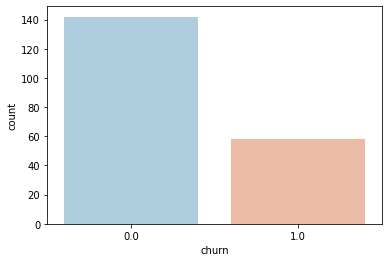

In [780]:
sns.countplot(data=df, x='churn', palette='RdBu_r')

We will deal with them by using random oversampling. We could also do random undersampling, but because we don't have a lot of data, we'll stick to the former.

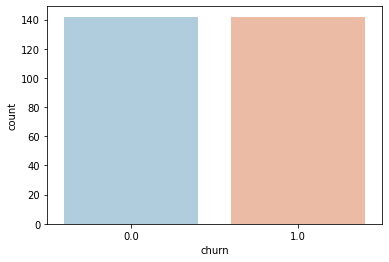

In [781]:
majority = df[df['churn'] == 0]
minority = df[df['churn'] == 1]

minority_upsampled = resample(minority, replace=True, n_samples=len(majority))

df = pd.concat([majority, minority_upsampled])

sns.countplot(data=df, x='churn', palette='RdBu_r')

## Attribute statistics

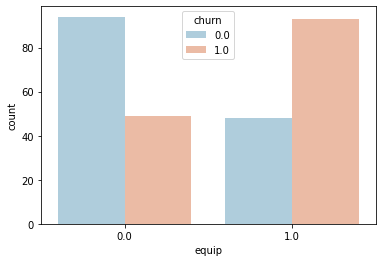

In [782]:
sns.countplot(data=df, x='equip', hue='churn', palette='RdBu_r')

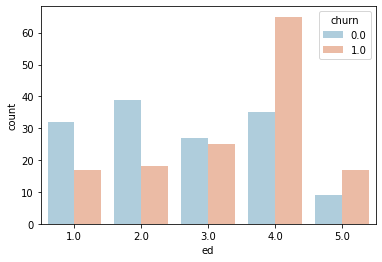

In [783]:
sns.countplot(data=df, x='ed', hue='churn', palette='RdBu_r')

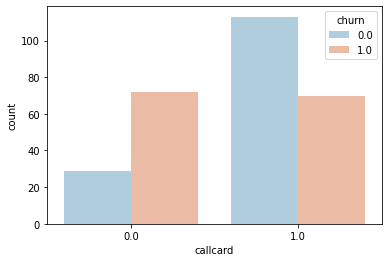

In [784]:
sns.countplot(data=df, x='callcard', hue='churn', palette='RdBu_r')

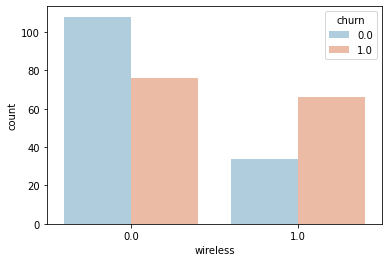

In [785]:
sns.countplot(data=df, x='wireless', hue='churn', palette='RdBu_r')

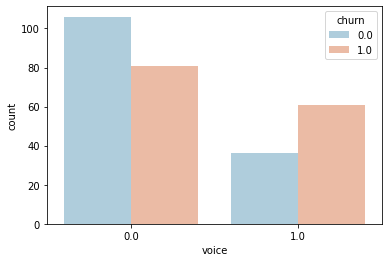

In [786]:
sns.countplot(data=df, x='voice', hue='churn', palette='RdBu_r')

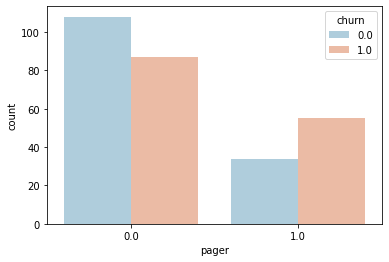

In [787]:
sns.countplot(data=df, x='pager', hue='churn', palette='RdBu_r')

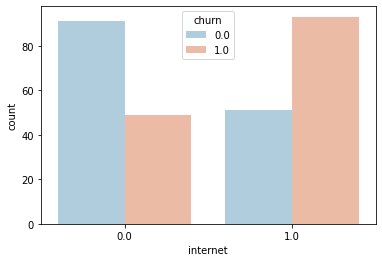

In [788]:
sns.countplot(data=df, x='internet', hue='churn', palette='RdBu_r')

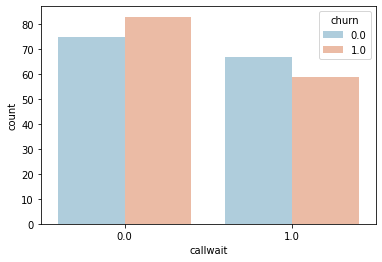

In [789]:
sns.countplot(data=df, x='callwait', hue='churn', palette='RdBu_r')

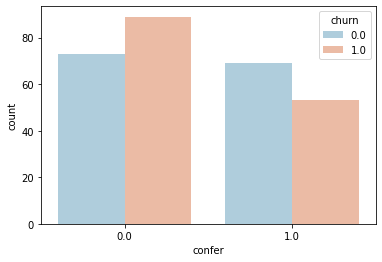

In [790]:
sns.countplot(data=df, x='confer', hue='churn', palette='RdBu_r')

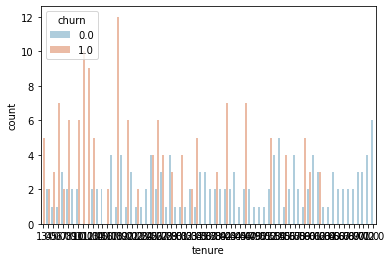

In [791]:
sns.countplot(data=df, x='tenure', hue='churn', palette='RdBu_r')

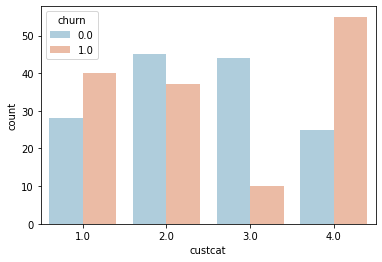

In [792]:
sns.countplot(data=df, x='custcat', hue='churn', palette='RdBu_r')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90c0dc6910>,
      dtype=object)

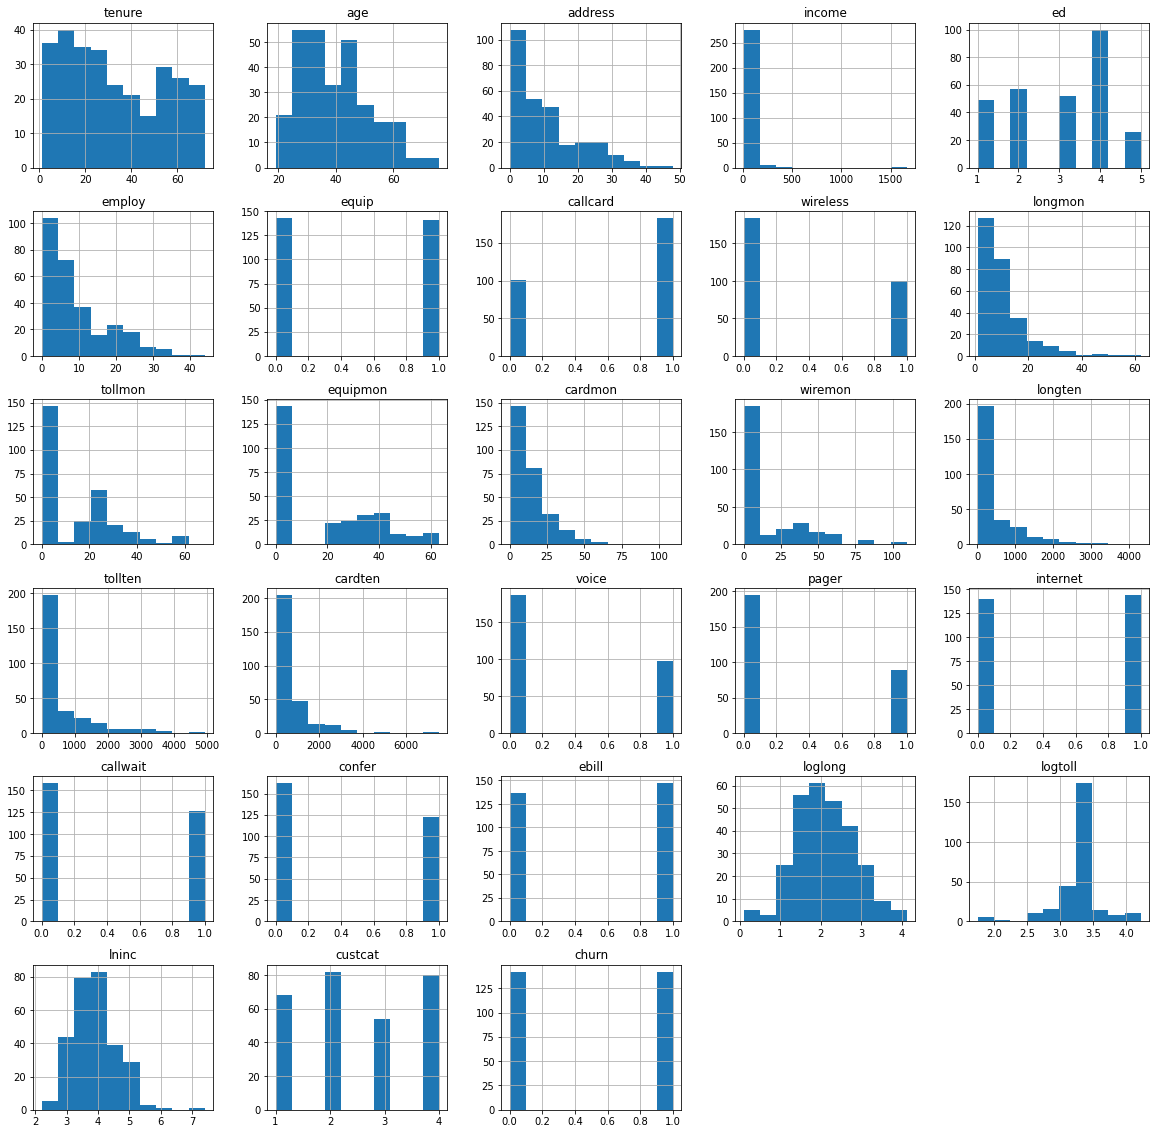

In [793]:
df.hist(figsize = (20, 20))

From the histograms we can see that *loglong*, *logtoll*, and *lninc* have more or less a standard normal distribution.

## Missing values

In [794]:
df.isnull().sum()

tenure      0
age         0
address     0
income      0
ed          0
employ      0
equip       0
callcard    0
wireless    0
longmon     0
tollmon     0
equipmon    0
cardmon     0
wiremon     0
longten     0
tollten     0
cardten     0
voice       0
pager       0
internet    0
callwait    0
confer      0
ebill       0
loglong     0
logtoll     0
lninc       0
custcat     0
churn       0
dtype: int64

tenure         AxesSubplot(0.125,0.816017;0.227941x0.0639831)
age         AxesSubplot(0.398529,0.816017;0.227941x0.0639831)
address     AxesSubplot(0.672059,0.816017;0.227941x0.0639831)
income         AxesSubplot(0.125,0.739237;0.227941x0.0639831)
ed          AxesSubplot(0.398529,0.739237;0.227941x0.0639831)
employ      AxesSubplot(0.672059,0.739237;0.227941x0.0639831)
equip          AxesSubplot(0.125,0.662458;0.227941x0.0639831)
callcard    AxesSubplot(0.398529,0.662458;0.227941x0.0639831)
wireless    AxesSubplot(0.672059,0.662458;0.227941x0.0639831)
longmon        AxesSubplot(0.125,0.585678;0.227941x0.0639831)
tollmon     AxesSubplot(0.398529,0.585678;0.227941x0.0639831)
equipmon    AxesSubplot(0.672059,0.585678;0.227941x0.0639831)
cardmon        AxesSubplot(0.125,0.508898;0.227941x0.0639831)
wiremon     AxesSubplot(0.398529,0.508898;0.227941x0.0639831)
longten     AxesSubplot(0.672059,0.508898;0.227941x0.0639831)
tollten        AxesSubplot(0.125,0.432119;0.227941x0.0639831)
cardten 

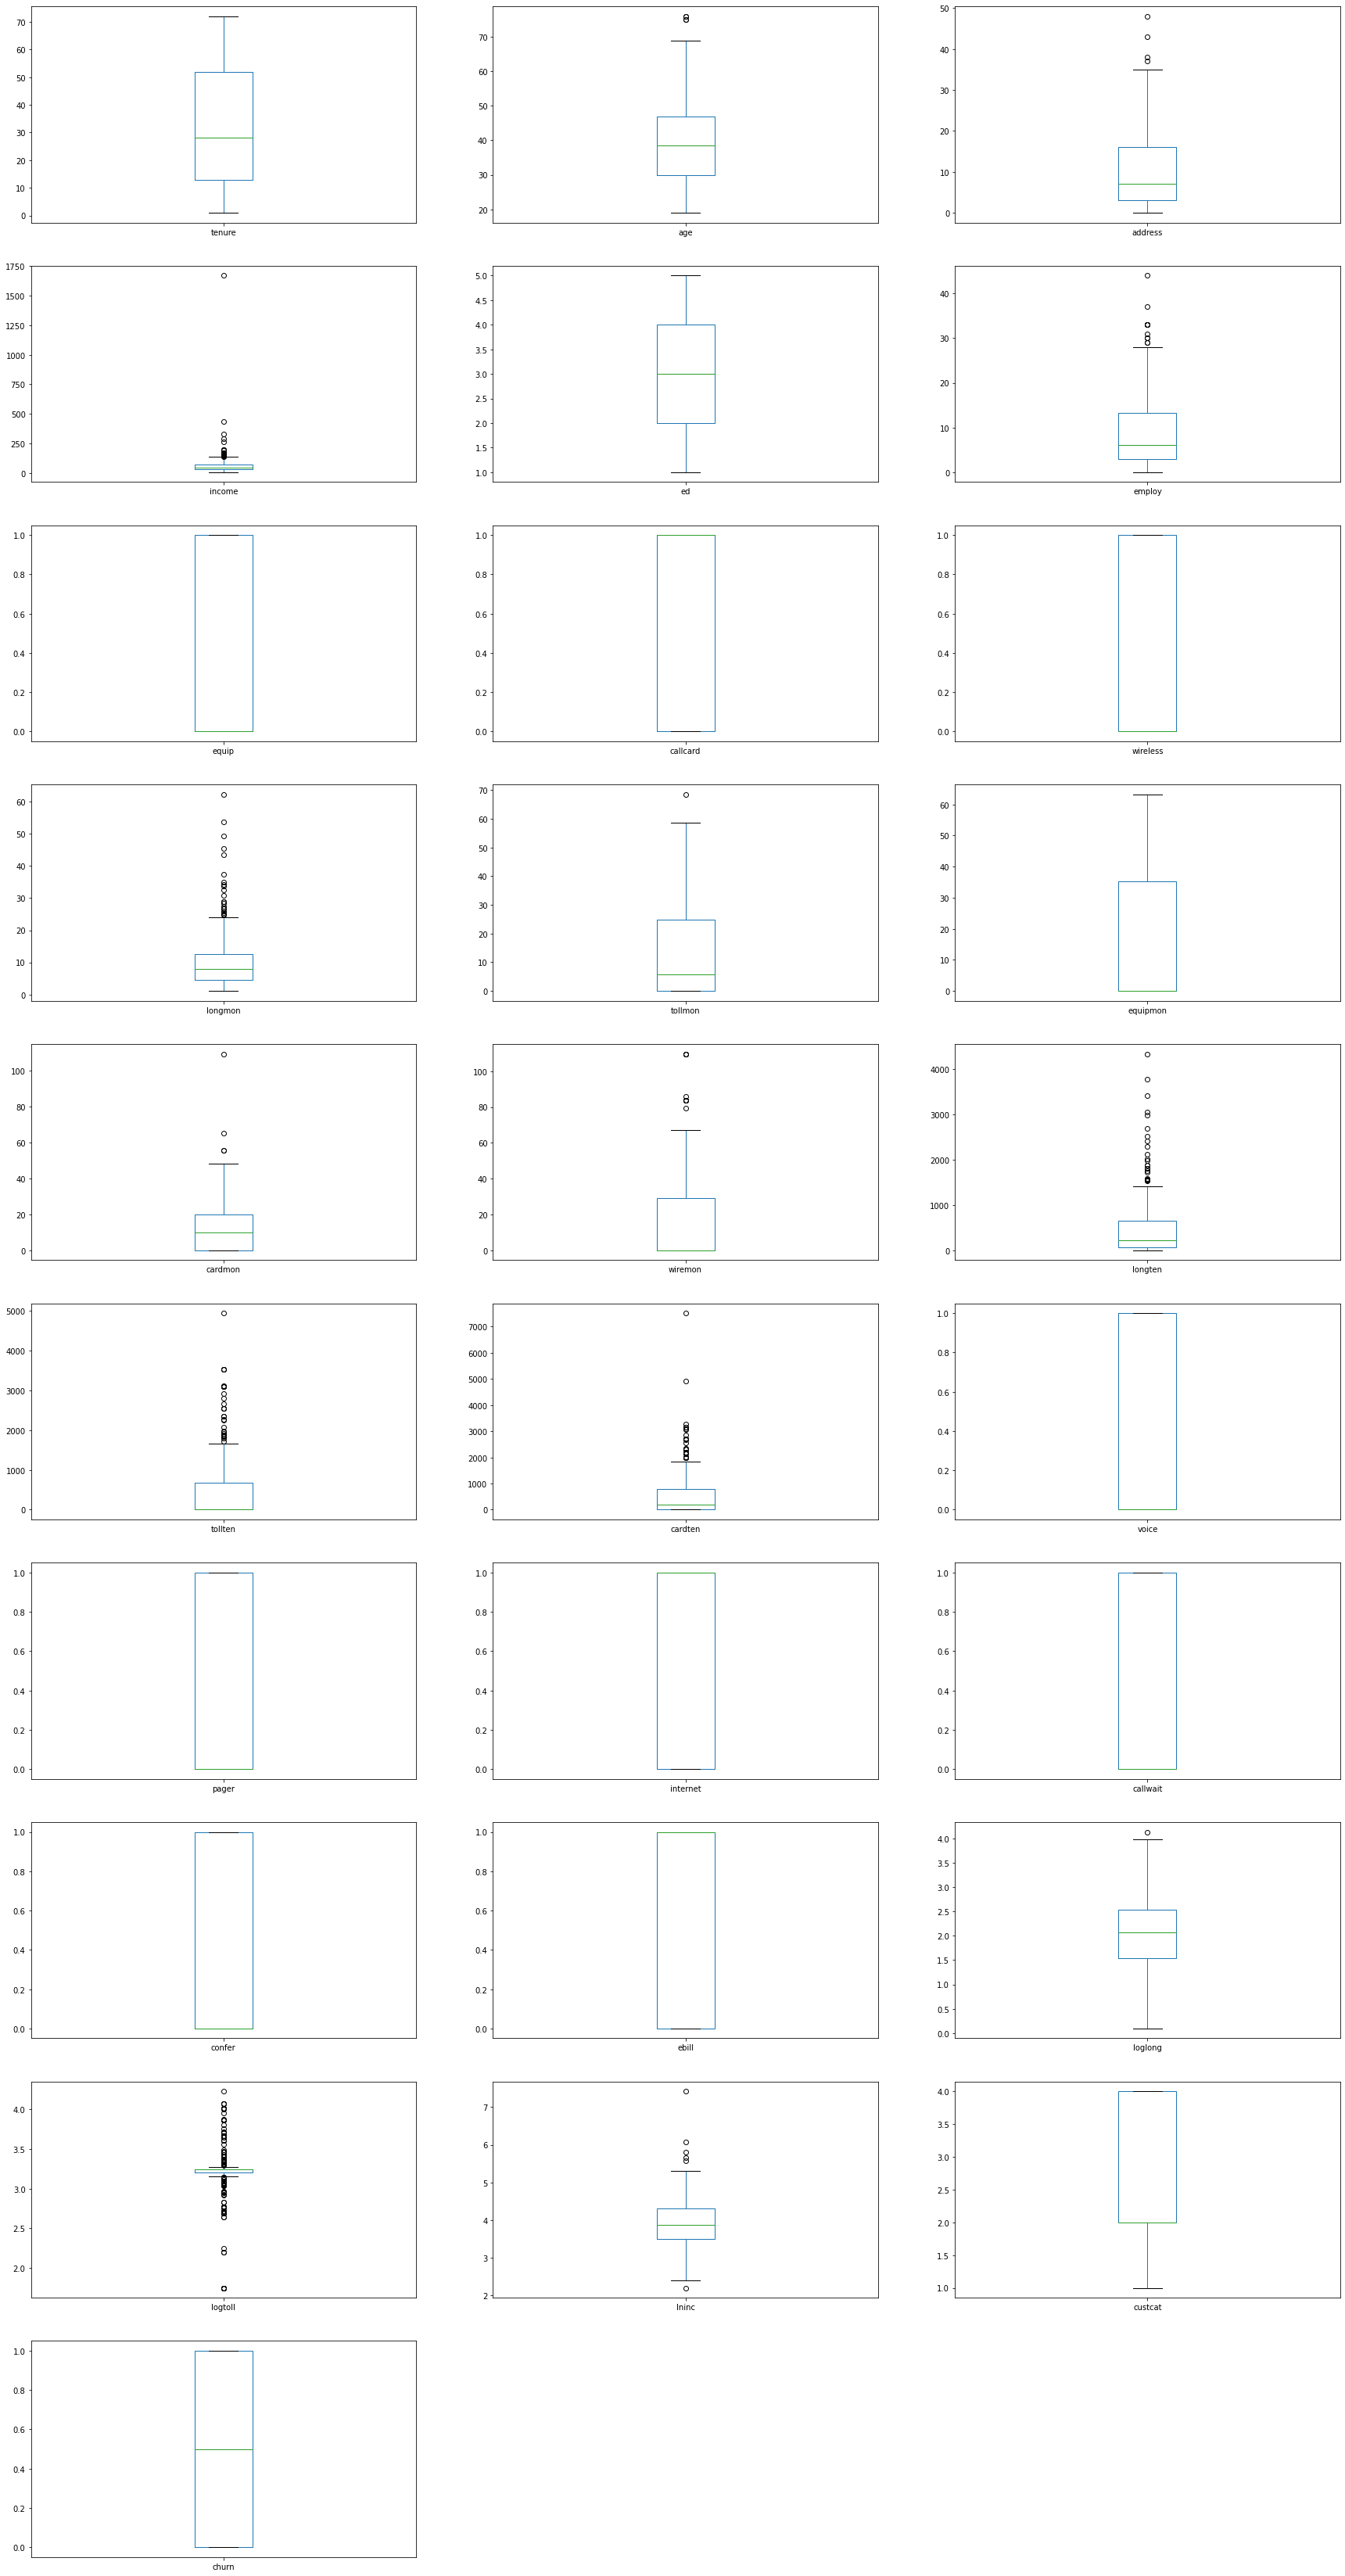

In [795]:
df.plot(kind='box', subplots=True, layout=(-1, 3), figsize=(30, 60))

Some features have quite a bit of outliers!

## Exploratory Data Analysis

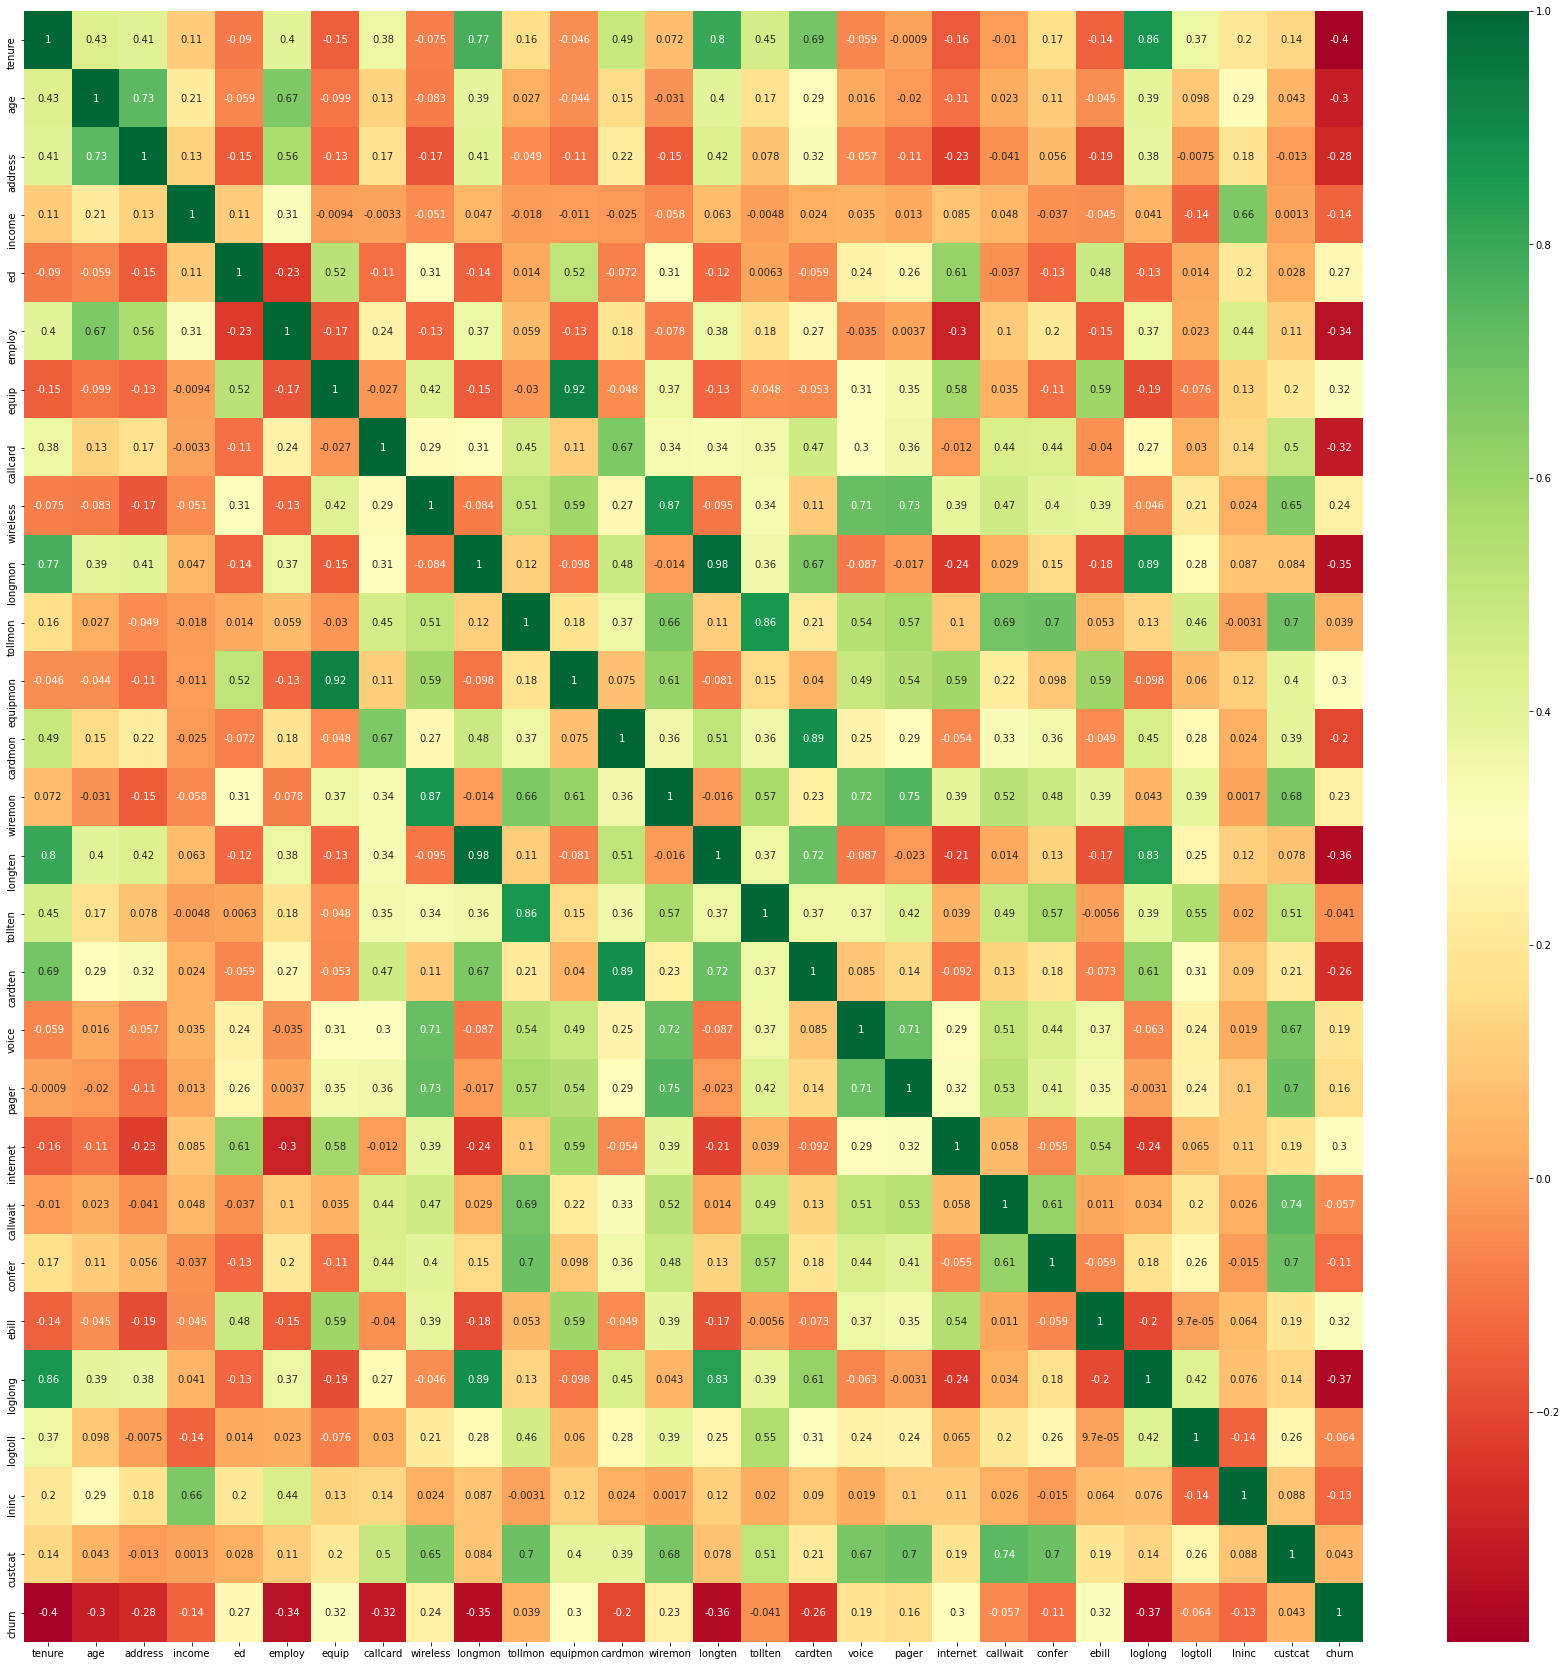

In [796]:
# Get the correlations for each feature
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (30, 30))

# Plot them via a heat map
g = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

By looking at the last row, we can see that *tenure*, *employ*, *loglong*, *longten*, *longmon*, *callcard* and *age* are negatively correlated - the lower they are, the higher the *churn* rate.

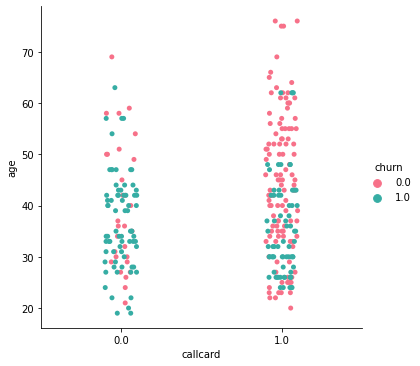

In [797]:
sns.catplot(data=df, x="callcard", y="age", hue="churn", palette="husl")

Elderly customers with *callcard* have a lower churn rate!

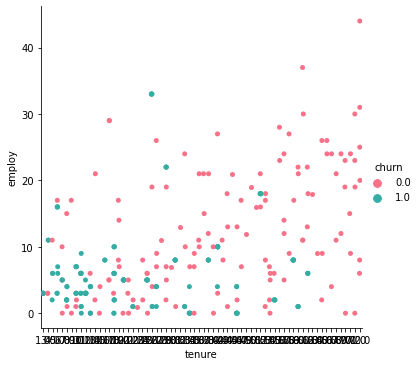

In [798]:
sns.catplot(data=df, x="tenure", y="employ", hue="churn", palette="husl")

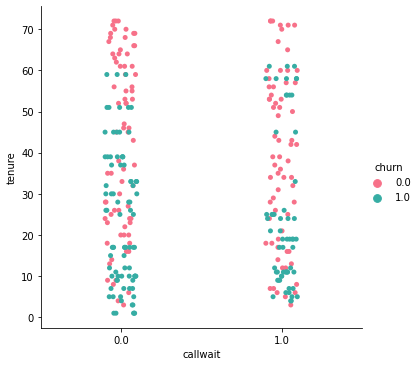

In [799]:
sns.catplot(data=df, x="callwait", y="tenure", hue="churn", palette="husl")

Customers with higher *tenure* have a lower churn rate!

In [800]:
#sns.pairplot(df)

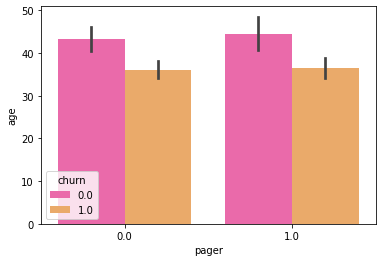

In [801]:
sns.barplot(data=df, x="pager", y="age", hue="churn", palette="spring")

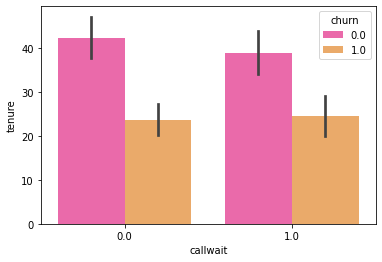

In [802]:
sns.barplot(data=df, x="callwait", y="tenure", hue="churn", palette="spring")

## Cross Tables.

In [803]:
gen = pd.crosstab(df.callwait, df.churn)
gen

churn,0.0,1.0
callwait,,
0.0,75,83
1.0,67,59


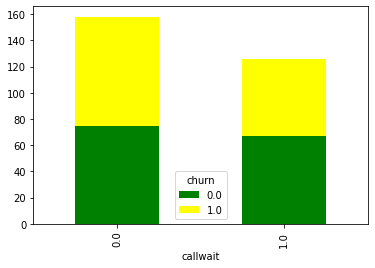

In [804]:
gen.plot(kind='bar', stacked=True, color=['green', 'yellow'], grid=False)

In [805]:
gen = pd.crosstab(index=df.equip, columns=[df.callcard], margins=True)
gen

callcard,0.0,1.0,All
equip,,,
0.0,49,94,143
1.0,52,89,141
All,101,183,284


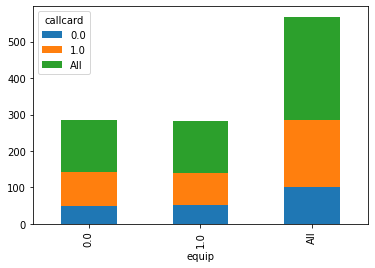

In [806]:
gen.plot(kind='bar', stacked='True')
plt.show()

In [807]:
gen = pd.crosstab(df.voice, df.pager)
gen

pager,0.0,1.0
voice,,
0.0,173,14
1.0,22,75


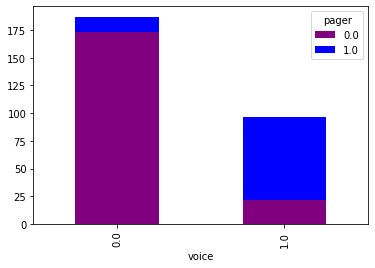

In [808]:
gen.plot(kind='bar', stacked=True, color=['purple', 'blue'], grid=False)

## Feature Selection

In [809]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 2 to 157
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    284 non-null    float64
 1   age       284 non-null    float64
 2   address   284 non-null    float64
 3   income    284 non-null    float64
 4   ed        284 non-null    float64
 5   employ    284 non-null    float64
 6   equip     284 non-null    float64
 7   callcard  284 non-null    float64
 8   wireless  284 non-null    float64
 9   longmon   284 non-null    float64
 10  tollmon   284 non-null    float64
 11  equipmon  284 non-null    float64
 12  cardmon   284 non-null    float64
 13  wiremon   284 non-null    float64
 14  longten   284 non-null    float64
 15  tollten   284 non-null    float64
 16  cardten   284 non-null    float64
 17  voice     284 non-null    float64
 18  pager     284 non-null    float64
 19  internet  284 non-null    float64
 20  callwait  284 non-null    float6

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,voice,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,0.0,0.0,0.00,0.0,157.05,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,45.0,50.1,23.25,64.9,239.55,1873.05,880.0,1.0,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,22.0,0.0,23.75,0.0,47.45,166.10,145.0,1.0,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0
5,68.0,52.0,17.0,120.0,1.0,24.0,0.0,1.0,0.0,20.70,0.0,0.0,22.00,0.0,1391.05,0.00,1505.0,0.0,0.0,0.0,0.0,0.0,0.0,3.030,3.240,4.787,1.0,0.0
6,42.0,40.0,7.0,37.0,2.0,8.0,1.0,1.0,1.0,8.25,23.5,36.9,28.00,37.4,399.15,950.65,1190.0,1.0,0.0,1.0,1.0,1.0,1.0,2.110,3.157,3.611,4.0,0.0


Let's scale the numeric values and convert the categorical variables into dummy ones.

In [810]:
# Convert into dummy variables.
dataset = pd.get_dummies(df, columns = ['ed', 'equip', 'callcard', 'wireless', 'voice', 'pager', 'internet', 'callwait', 'confer', 'ebill', 'custcat'])

In [811]:
dataset.head()

,tenure,age,address,income,employ,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,loglong,logtoll,lninc,churn,ed_1.0,ed_2.0,ed_3.0,ed_4.0,ed_5.0,equip_0.0,equip_1.0,callcard_0.0,callcard_1.0,wireless_0.0,wireless_1.0,voice_0.0,voice_1.0,pager_0.0,pager_1.0,internet_0.0,internet_1.0,callwait_0.0,callwait_1.0,confer_0.0,confer_1.0,ebill_0.0,ebill_1.0,custcat_1.0,custcat_2.0,custcat_3.0,custcat_4.0
2,23.0,30.0,9.0,30.0,2.0,6.30,0.0,0.0,0.00,0.0,157.05,0.00,0.0,1.841,3.240,3.401,0.0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0
3,38.0,35.0,5.0,76.0,10.0,6.05,45.0,50.1,23.25,64.9,239.55,1873.05,880.0,1.800,3.807,4.331,0.0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1
4,7.0,35.0,14.0,80.0,15.0,7.10,22.0,0.0,23.75,0.0,47.45,166.10,145.0,1.960,3.091,4.382,0.0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
5,68.0,52.0,17.0,120.0,24.0,20.70,0.0,0.0,22.00,0.0,1391.05,0.00,1505.0,3.030,3.240,4.787,0.0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0
6,42.0,40.0,7.0,37.0,8.0,8.25,23.5,36.9,28.00,37.4,399.15,950.65,1190.0,2.110,3.157,3.611,0.0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1


In [812]:
# Move the target column to the back
filter_cols = ['churn']
dataset = dataset[[c for c in dataset if c not in filter_cols] + ['churn']]

In [813]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 2 to 157
Data columns (total 44 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tenure        284 non-null    float64
 1   age           284 non-null    float64
 2   address       284 non-null    float64
 3   income        284 non-null    float64
 4   employ        284 non-null    float64
 5   longmon       284 non-null    float64
 6   tollmon       284 non-null    float64
 7   equipmon      284 non-null    float64
 8   cardmon       284 non-null    float64
 9   wiremon       284 non-null    float64
 10  longten       284 non-null    float64
 11  tollten       284 non-null    float64
 12  cardten       284 non-null    float64
 13  loglong       284 non-null    float64
 14  logtoll       284 non-null    float64
 15  lninc         284 non-null    float64
 16  ed_1.0        284 non-null    uint8  
 17  ed_2.0        284 non-null    uint8  
 18  ed_3.0        284 non-null    

In [814]:
dataset.head()

,tenure,age,address,income,employ,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,loglong,logtoll,lninc,ed_1.0,ed_2.0,ed_3.0,ed_4.0,ed_5.0,equip_0.0,equip_1.0,callcard_0.0,callcard_1.0,wireless_0.0,wireless_1.0,voice_0.0,voice_1.0,pager_0.0,pager_1.0,internet_0.0,internet_1.0,callwait_0.0,callwait_1.0,confer_0.0,confer_1.0,ebill_0.0,ebill_1.0,custcat_1.0,custcat_2.0,custcat_3.0,custcat_4.0,churn
2,23.0,30.0,9.0,30.0,2.0,6.30,0.0,0.0,0.00,0.0,157.05,0.00,0.0,1.841,3.240,3.401,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0.0
3,38.0,35.0,5.0,76.0,10.0,6.05,45.0,50.1,23.25,64.9,239.55,1873.05,880.0,1.800,3.807,4.331,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0.0
4,7.0,35.0,14.0,80.0,15.0,7.10,22.0,0.0,23.75,0.0,47.45,166.10,145.0,1.960,3.091,4.382,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0.0
5,68.0,52.0,17.0,120.0,24.0,20.70,0.0,0.0,22.00,0.0,1391.05,0.00,1505.0,3.030,3.240,4.787,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0.0
6,42.0,40.0,7.0,37.0,8.0,8.25,23.5,36.9,28.00,37.4,399.15,950.65,1190.0,2.110,3.157,3.611,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0.0


In [815]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, 0:27], dataset.iloc[:, -1])

In [816]:
X_train.head()

,tenure,age,address,income,employ,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,loglong,logtoll,lninc,ed_1.0,ed_2.0,ed_3.0,ed_4.0,ed_5.0,equip_0.0,equip_1.0,callcard_0.0,callcard_1.0,wireless_0.0,wireless_1.0
163,58.0,37.0,5.0,64.0,8.0,10.80,58.75,63.25,37.75,109.70,634.75,3525.55,2305.0,2.380,4.073,4.159,0,0,0,1,0,0,1,0,1,0,1
95,11.0,63.0,9.0,41.0,3.0,4.15,0.00,29.90,0.00,0.00,46.35,0.00,0.0,1.423,3.240,3.714,0,0,1,0,0,0,1,1,0,1,0
178,37.0,33.0,4.0,41.0,8.0,9.20,0.00,30.45,0.00,0.00,347.10,0.00,0.0,2.219,3.240,3.714,0,0,1,0,0,0,1,1,0,1,0
99,53.0,33.0,1.0,60.0,6.0,17.65,28.50,0.00,41.00,28.55,950.70,1502.20,2170.0,2.871,3.350,4.094,1,0,0,0,0,1,0,0,1,0,1
107,7.0,27.0,3.0,39.0,2.0,3.55,0.00,0.00,0.00,0.00,19.70,0.00,0.0,1.267,3.240,3.664,0,0,1,0,0,1,0,1,0,1,0


In [817]:
y_train.head()

163    1.0
95     1.0
178    1.0
99     0.0
107    1.0
Name: churn, dtype: float64

In [818]:
X_test.head()

,tenure,age,address,income,employ,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,loglong,logtoll,lninc,ed_1.0,ed_2.0,ed_3.0,ed_4.0,ed_5.0,equip_0.0,equip_1.0,callcard_0.0,callcard_1.0,wireless_0.0,wireless_1.0
171,59.0,26.0,3.0,41.0,1.0,12.65,0.0,35.10,46.75,29.15,804.00,0.0,2710.0,2.538,3.24,3.714,0,0,0,1,0,0,1,0,1,0,1
147,70.0,35.0,4.0,48.0,9.0,43.60,0.0,0.00,30.00,0.00,3040.80,0.0,2020.0,3.775,3.24,3.871,0,1,0,0,0,1,0,0,1,1,0
138,45.0,34.0,14.0,43.0,0.0,6.55,0.0,32.35,0.00,0.00,315.20,0.0,0.0,1.879,3.24,3.761,0,0,0,1,0,0,1,1,0,1,0
127,10.0,40.0,6.0,22.0,6.0,5.05,0.0,0.00,0.00,0.00,59.95,0.0,0.0,1.619,3.24,3.091,0,0,1,0,0,1,0,1,0,1,0
146,6.0,29.0,4.0,19.0,5.0,4.20,0.0,0.00,0.00,0.00,25.25,0.0,0.0,1.435,3.24,2.944,0,1,0,0,0,1,0,1,0,1,0


In [819]:
y_test.head()

171    1.0
147    0.0
138    1.0
127    1.0
146    0.0
Name: churn, dtype: float64

In [820]:
# Univariate Selection
# Chi-Squared test to get top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

number_features = 10

best_features = SelectKBest(score_func=chi2, k=number_features)
fit = best_features.fit(X_train, y_train)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['specs', 'score']

feature_scores.nlargest(number_features, 'score')

,specs,score
10,longten,20124.244376
12,cardten,17559.124626
3,income,713.976921
0,tenure,477.725164
9,wiremon,385.618328
7,equipmon,266.197047
2,address,211.951921
4,employ,202.021396
5,longmon,157.466247
8,cardmon,122.365031


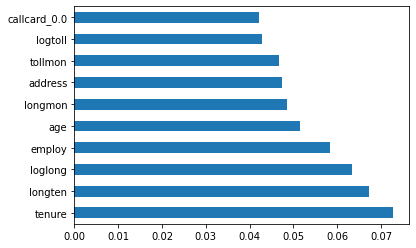

In [821]:
# Feature Importance
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_train, y_train)

feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(number_features).plot(kind='barh')
plt.show()

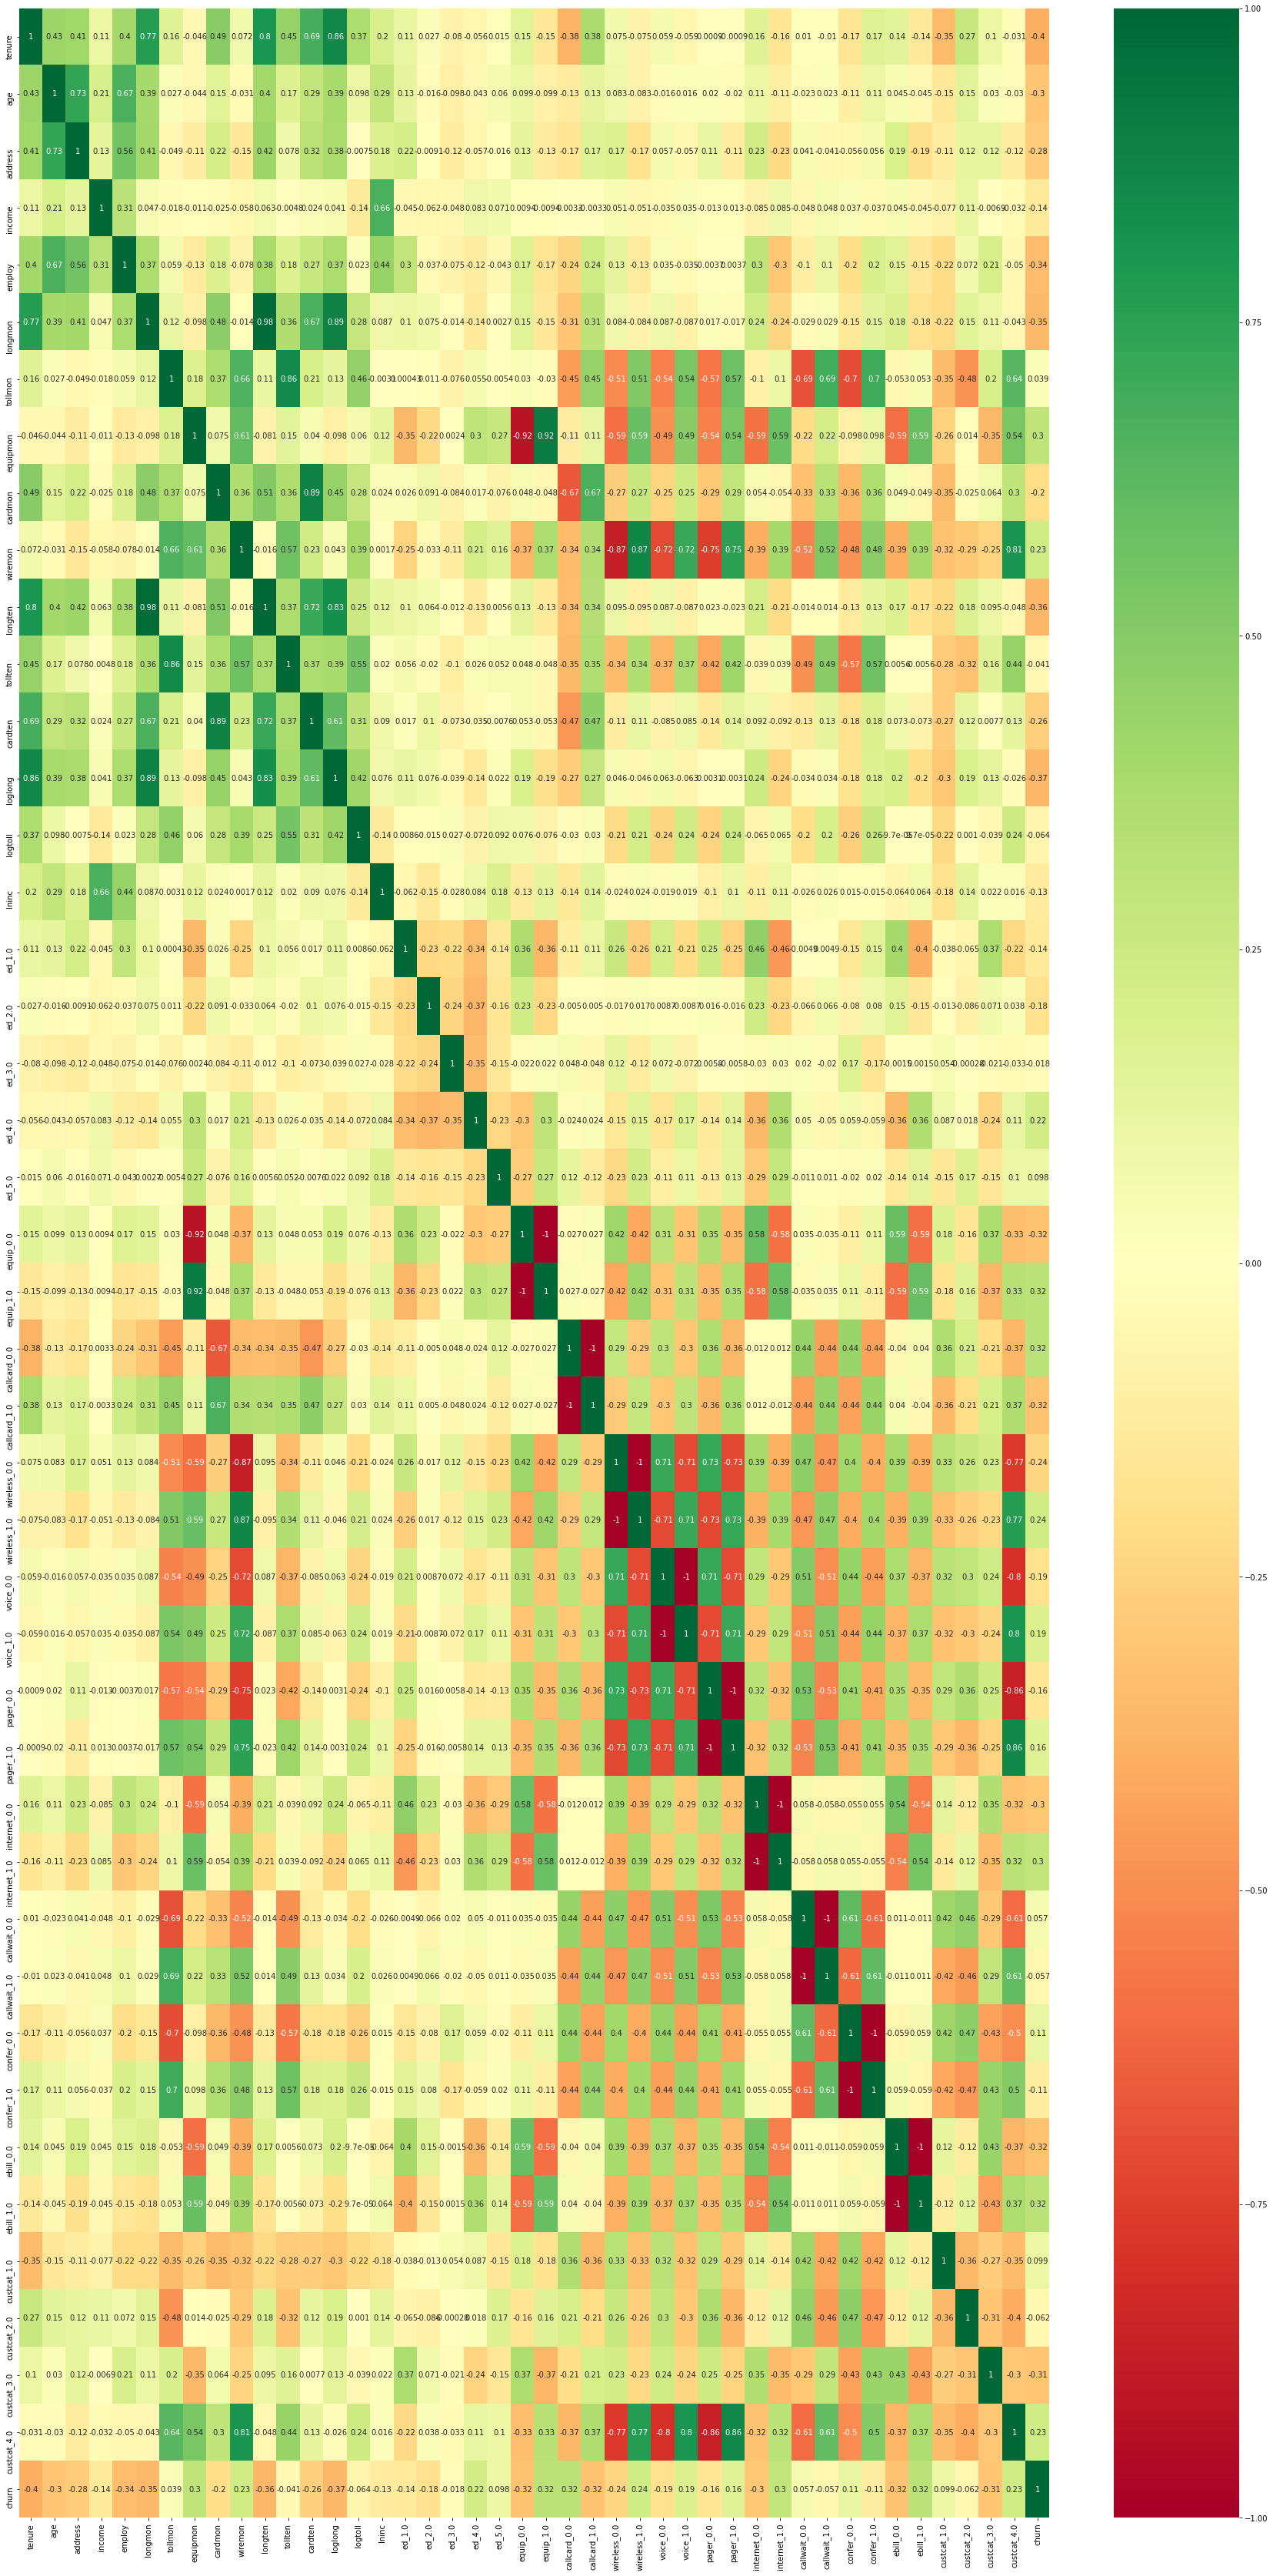

In [822]:
# Get the correlations for each feature
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (30, 60))

# Plot them via a heat map
g = sns.heatmap(dataset[top_corr_features].corr(), annot=True, cmap="RdYlGn")

As a result of the three strategies, it seems that the **best features** are:

    longmon
    longten
    loglong
    cardten
    tollten
    tenure
    employ
    callcard_0.0

In [823]:
# Scale the numeric variables
scaler = StandardScaler()
columns_to_scale = ['tenure', 'age', 'address', 'income', 'employ', 'longmon', 'tollmon', 'equipmon', 'cardmon', 'wiremon', 'longten', 'tollten', 'cardten', 'loglong', 'logtoll', 'lninc']
dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])

In [824]:
# Select best features!
filter_cols = [
'longmon',
'longten',
'loglong',
'cardten',
'tollten',
'tenure',
'employ',
'callcard_0.0',
'churn'
]
dataset = dataset[[c for c in dataset if c in filter_cols]]
dataset.head()

,tenure,employ,longmon,longten,tollten,cardten,loglong,callcard_0.0,churn
2,-0.447955,-0.840308,-0.477362,-0.487509,-0.597692,-0.631770,-0.341691,1,0.0
3,0.267832,0.091909,-0.505640,-0.362923,1.625110,0.362426,-0.398592,0,0.0
4,-1.211460,0.674544,-0.386872,-0.653018,-0.400577,-0.467954,-0.176538,0,0.0
5,1.699405,1.723288,1.151456,1.375985,-0.597692,1.068531,1.308444,0,0.0
6,0.458708,-0.141145,-0.256793,-0.121907,0.530471,0.712654,0.031637,0,0.0


In [825]:
class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class Adaboost():

    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()

            min_error = float('inf')
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

In [830]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

for stump in [23, 24, 25, 26, 27, 28, 29, 30, 31, 32]:
  X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, 0:8], dataset.iloc[:, -1])

  X_train = X_train.to_numpy()
  X_test = X_test.to_numpy()

  clf = Adaboost(n_clf=stump)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  acc = accuracy(y_test, y_pred)
  print (f"stump={stump}, accuracy={acc}")

stump=23, accuracy=0.4788732394366197
stump=24, accuracy=0.5352112676056338
stump=25, accuracy=0.5492957746478874
stump=26, accuracy=0.4788732394366197
stump=27, accuracy=0.49295774647887325
stump=28, accuracy=0.49295774647887325
stump=29, accuracy=0.5352112676056338
stump=30, accuracy=0.4788732394366197
stump=31, accuracy=0.4225352112676056
stump=32, accuracy=0.43661971830985913


The best model seems to be able to achieve around 55% accuracy.

In [831]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

clf.predict(X_test)

clf.score(X_test, y_test)

0.7605633802816901

The built-in model in sklearn is able to achive an accuracy of 76%.